In [2]:
# Imports
import sys

sys.path.insert(0, "../../src")
from main import load_database

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import yaml

In [3]:
# Load the labels DataFrame
# Load the experiment configuration from the YAML file
with open("../../src/experiment_parameters.yaml", "r") as stream:
    config = yaml.safe_load(stream)

df_files = load_database(config)

Number of participants before filtering out too few sessions: 27; Shape of the DataFrame before filtering: (3346, 152)
Number of participants after filtering out too few sessions: 25; Shape of the DataFrame after filtering: (3304, 152)
Shape of the DataFrame after filtering prompts: (3204, 152)


In [4]:
# Calculate the total audio duration
import audeer
from audiofile import duration
from datetime import timedelta

# Get the 'file' level of the MultiIndex
file_level = df_files.index.get_level_values("file")

# Initialize a variable to store the total duration
total_duration_s = 0

# Iterate over each file
for file in audeer.progress_bar(file_level):
    # Calculate the duration of the file and add it to the total
    total_duration_s += duration(file, sloppy=False)

# Convert the total duration to a timedelta object
total_duration = timedelta(seconds=total_duration_s)

# Print the total duration
print(f"Total audio duration: {total_duration}, which are {total_duration_s} s")

Total audio duration: 7:09:58.889375, which are 25798.88937500017 s


In [5]:
# Use also filtered DataFrame with standardized speechtasks only

df_files_filtered = pd.read_csv(
    "data/feature_analysis/extended_analysis_attempt_02/df_files-filtered_denoised-vad_devaice.csv"
)

In [6]:
def fix_indices(df):
    # Convert the indices to the timedelta format
    # Labels DataFrame
    df["file"] = df["file"].astype(str)
    df["start"] = df["start"].apply(pd.to_timedelta)
    df["end"] = df["end"].apply(pd.to_timedelta)
    # Restore the MultiIndex
    df.set_index(["file", "start", "end"], inplace=True)
    return df

In [7]:
# Calculate the total audio duration
import audeer
from audiofile import duration
from datetime import timedelta

df_files_filtered = fix_indices(df_files_filtered)

# Get the 'file' level of the MultiIndex
file_level = df_files_filtered.index.get_level_values("file")

# Initialize a variable to store the total duration
total_duration_s = 0

# Iterate over each file
for file in audeer.progress_bar(file_level):
    # Calculate the duration of the file and add it to the total
    total_duration_s += duration(file, sloppy=False)

# Convert the total duration to a timedelta object
total_duration = timedelta(seconds=total_duration_s)

# Print the total duration
print(f"Total audio duration: {total_duration}, which are {total_duration_s} s")

  0%|                         [00:00<?]                                                             

Total audio duration: 20:50:20.342313, which are 75020.3423125004 s


# Check how many samples were clipped and with a high SNR value here

In [8]:
def filter_audio_quality(df_files, cwd, config, cfg_processing):

    cfg_filter = config
    with open(os.path.join(cwd, cfg_filter["path_blacklist"]), "r") as file:
        dct_filter_files = yaml.safe_load(file)

    # Get the current denoising setting to fetch the correct blacklist
    cur_denoising = list(cfg_processing["denoising"].keys())[0]

    # Select the set of blacklisted files based on the denoising approach used
    yaml_blacklists = dct_filter_files[cur_denoising]

    cfg_blacklists = cfg_filter["filter_lists"]

    # Initialise the DataFrame to be returned - in case no filter is applied
    df_files_filtered = df_files.copy()
    if cfg_blacklists:
        print("Performing audio-quality-based filtering")
        len_all_duplicates = 0
        blacklists = set()
        for key in cfg_blacklists:
            len_cur_lst = 0
            if key in yaml_blacklists:
                for item in yaml_blacklists[key]:
                    if item in blacklists:
                        print(f"Duplicate item: {item}")
                        len_all_duplicates += 1
                    else:
                        blacklists.add(item)
                        len_cur_lst += 1
                print(f"Adding {key} with {len_cur_lst} samples.")
            else:
                warnings.warn(f"List {key} not found in the blacklists.")
        print(
            f"Filtered out {len(blacklists)} samples. The blacklists overlapped by {len_all_duplicates} duplicate sample(s)."
        )

        # Use the blacklists to filter the dataframe
        df_files_filtered = df_files[
            ~df_files.index.get_level_values("file").isin(blacklists)
        ]

        # Verify that the number of files in the filtered DataFrame matches the expected number of files after filtering
        # assert len(df_files) - len(blacklists) == len(
        #     df_files_filtered
        # ), "The number of files in the filtered DataFrame does not match the expected number of files after filtering."
    else:
        print("No lists for audio-quality-based filtering provided.")

    return df_files_filtered, blacklists

In [9]:
# Denoised data

config = {
    "path_blacklist": "experiment_configs/mental_wellbeing_at_sea/filter_files.yaml",
    "filter_lists": ["snr_tuckey_cutoff_7", "clipped_default"],
}
cfg_processing = {
    "denoising": {"facebook_denoiser-master64-converted_int16_dithering": None}
}

df_files_filtered_denoised, blacklists_denoised = filter_audio_quality(
    df_files_filtered,
    "/data/phecker/project/audiary/projects/prompt-performance/modelling-static/src",
    config,
    cfg_processing,
)

Performing audio-quality-based filtering
Adding snr_tuckey_cutoff_7 with 676 samples.
Adding clipped_default with 0 samples.
Filtered out 676 samples. The blacklists overlapped by 0 duplicate sample(s).


In [10]:
import os

# Get the 'file' level of the MultiIndex and extract the last part of the path
file_level_strings = [
    os.path.basename(file)[:-4]
    for file in df_files_filtered.index.get_level_values("file")
]
print(
    f"File level strings: {file_level_strings[:10]}"
)  # Print the first 10 for brevity

# Convert to set
file_level_set = set(file_level_strings)

# Extract the last part of the path from blacklists_denoised
blacklists_denoised_strings = [
    os.path.basename(file)[:-4] for file in blacklists_denoised
]
print(
    f"Blacklists denoised strings: {blacklists_denoised_strings[:10]}"
)  # Print the first 10 for brevity

# Convert to set
blacklists_denoised_set = set(blacklists_denoised_strings)

# Find the intersection of the two sets
common_files = file_level_set & blacklists_denoised_set

# Print the number of common files
print(
    f"Number of samples of blacklists_denoised in df_files_filtered: {len(common_files)}"
)

File level strings: ['0784b3e9-ff56-47cb-805c-d58fa2784eba', '0784b3e9-ff56-47cb-805c-d58fa2784eba', '2dcf42d7-6030-45de-806e-8882081e1180', '2dcf42d7-6030-45de-806e-8882081e1180', '350d81a8-c6bb-4c03-b006-9aafa0f8e99c', '350d81a8-c6bb-4c03-b006-9aafa0f8e99c', '3ba23ef3-3bdd-41f0-bfd6-61ed5a92acdf', '3ba23ef3-3bdd-41f0-bfd6-61ed5a92acdf', '40179871-a18d-406f-a47e-69743d28167b', '4efdf84b-5aa1-48f2-a991-a51ac367c140']
Blacklists denoised strings: ['4968e8e4-751b-422b-b633-b32a959d47c0', '3f32801c-7fc6-4400-9e99-60f884efc50e', '1ffd3abe-0fcc-49bf-ad58-2333ec06e2a7', '4547f3ed-0bfd-423e-b44a-5de9e77f05f9', '00c4c040-cad9-47f8-8831-4d3710175a3d', '31129319-0424-4a4e-9546-50608bdcea1e', 'e6475fb9-26dd-4a4b-bafd-c5ec0013ee8c', '18a9261b-538a-481b-8b04-1d77fa4d4bea', '554a2f38-121f-4785-b829-70dcfdd89ef1', '4538f5ac-62c6-4458-8ea1-84098664629c']
Number of samples of blacklists_denoised in df_files_filtered: 0


In [11]:
len(blacklists_denoised_set)

676

In [12]:
# Non-denoised data

config = {
    "path_blacklist": "experiment_configs/mental_wellbeing_at_sea/filter_files.yaml",
    "filter_lists": ["snr_tuckey_cutoff_7", "clipped_default"],
}
cfg_processing = {"denoising": {"no_denoising": None}}

df_files_filtered_noisy, blacklists_noisy = filter_audio_quality(
    df_files_filtered,
    "/data/phecker/project/audiary/projects/prompt-performance/modelling-static/src",
    config,
    cfg_processing,
)

Performing audio-quality-based filtering
Adding snr_tuckey_cutoff_7 with 668 samples.
Duplicate item: /data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/319946-16c641e/375/4547f3ed-0bfd-423e-b44a-5de9e77f05f9.wav
Adding clipped_default with 16 samples.
Filtered out 684 samples. The blacklists overlapped by 1 duplicate sample(s).


In [13]:
import os

# Get the 'file' level of the MultiIndex and extract the last part of the path
file_level_strings = [
    os.path.basename(file)[:-4]
    for file in df_files_filtered.index.get_level_values("file")
]
print(
    f"File level strings: {file_level_strings[:10]}"
)  # Print the first 10 for brevity

# Convert to set
file_level_set = set(file_level_strings)

# Extract the last part of the path from blacklists_denoised
blacklists_noisy_strings = [os.path.basename(file)[:-4] for file in blacklists_noisy]
print(
    f"Blacklists denoised strings: {blacklists_noisy_strings[:10]}"
)  # Print the first 10 for brevity

# Convert to set
blacklists_noisy_set = set(blacklists_noisy_strings)

# Find the intersection of the two sets
common_files = file_level_set & blacklists_noisy_set

# Print the number of common files
print(
    f"Number of samples of blacklists_denoised in df_files_filtered: {len(common_files)}"
)

File level strings: ['0784b3e9-ff56-47cb-805c-d58fa2784eba', '0784b3e9-ff56-47cb-805c-d58fa2784eba', '2dcf42d7-6030-45de-806e-8882081e1180', '2dcf42d7-6030-45de-806e-8882081e1180', '350d81a8-c6bb-4c03-b006-9aafa0f8e99c', '350d81a8-c6bb-4c03-b006-9aafa0f8e99c', '3ba23ef3-3bdd-41f0-bfd6-61ed5a92acdf', '3ba23ef3-3bdd-41f0-bfd6-61ed5a92acdf', '40179871-a18d-406f-a47e-69743d28167b', '4efdf84b-5aa1-48f2-a991-a51ac367c140']
Blacklists denoised strings: ['10d030ba-007e-4251-a091-3f5e0ceed952', '98527be9-4222-489a-9263-f203913ebd27', '288ba93b-fd74-4be7-8af4-92eec22228c8', 'd865127c-827d-4c00-8adb-21e1dc880e2d', '47ff0e39-ce0a-48df-8d78-1bcf6acc5466', 'fd2bf54e-9a06-4303-9983-5a10be0cf16f', '49d6834d-ca52-4d39-91a9-46b2cc066f92', 'cc0051e2-959d-4613-ac55-a6da2f28d7b7', '2035569b-42b6-4d42-b80c-23d6658f3cbc', '760bdd09-b149-4d9e-bd61-bb8b04c9c640']
Number of samples of blacklists_denoised in df_files_filtered: 137


In [14]:
len(df_files_filtered)

4883

## Original section

In [15]:
# Drop duplicates based on participant_code and session
unique_session_df = df_files.drop_duplicates(subset=["participant_code", "session"])

In [16]:
# Calculate summary statistics for the entire population
summary_stats = unique_session_df["stress_current"].describe()

# Display the summary statistics
print(summary_stats)

count    378.000000
mean      13.322751
std       16.891966
min        0.000000
25%        2.000000
50%        8.000000
75%       17.000000
max      100.000000
Name: stress_current, dtype: float64


In [17]:
df_unique_participants = df_files.drop_duplicates(subset="participant_code")

In [18]:
print(df_unique_participants["age"].describe())

count    25.000000
mean     37.600000
std       9.345231
min      24.000000
25%      30.000000
50%      36.000000
75%      45.000000
max      59.000000
Name: age, dtype: float64


In [19]:
print(df_unique_participants["sex"].value_counts(dropna=False))

sex
male      23
female     2
Name: count, dtype: int64


In [20]:
df_unique_participants["education"].value_counts(dropna=False)

education
undergraduate_completed    18
secondary                   3
vocational_training         2
undergraduate               1
no_schooling                1
Name: count, dtype: int64

In [21]:
df_unique_participants["native_language"].value_counts(dropna=False)

native_language
filipino    18
croatian     3
thai         3
hindi        1
Name: count, dtype: int64

In [22]:
len(df_files.session.unique())

378

In [23]:
len(unique_session_df)

378

In [24]:
unique_session_df["survey"].value_counts(dropna=False)

survey
daily        262
weekly_01     60
baseline      25
final         17
weekly_02     14
Name: count, dtype: int64

In [25]:
print(unique_session_df.date_days.min())
print(unique_session_df.date_days.max())

2022-11-01
2023-02-08


/tmp/ipykernel_664642/1989354340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_session_df['date_days'] = pd.to_datetime(unique_session_df['date_days'])


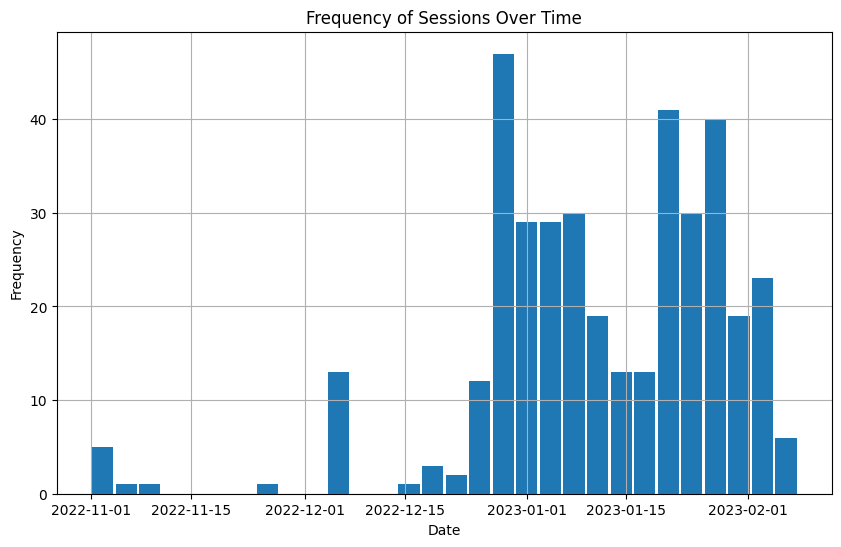

In [26]:
import matplotlib.pyplot as plt

# Convert date_days to datetime if it's not already
unique_session_df["date_days"] = pd.to_datetime(unique_session_df["date_days"])

# Plot histogram
plt.figure(figsize=(10, 6))
unique_session_df["date_days"].hist(rwidth=0.9, bins=30)
plt.title("Frequency of Sessions Over Time")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.show()

In [27]:
df_unique_participants["smoking_habit"].value_counts(dropna=False)

smoking_habit
non_smoker       16
daily_smoker      4
casual_smoker     3
heavy_smoker      2
Name: count, dtype: int64

In [28]:
df_unique_participants["rank_on_vessel"].value_counts(dropna=False)
# Probably not to be used, since the designation changes

rank_on_vessel
deck        15
engine       8
catering     2
Name: count, dtype: int64

In [29]:
unique_session_df
print(df_unique_participants["education"].describe())

count                          25
unique                          5
top       undergraduate_completed
freq                           18
Name: education, dtype: object


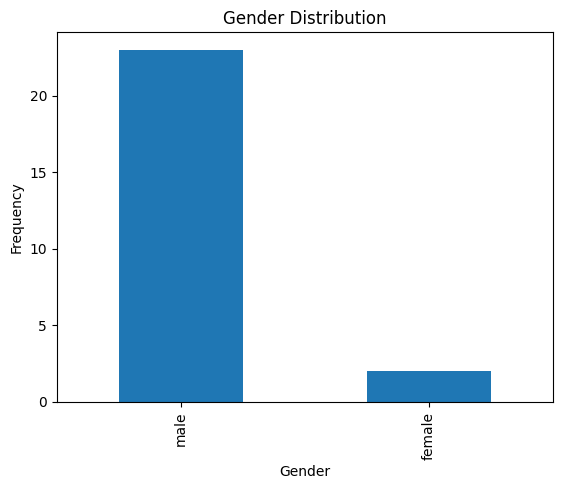

In [30]:
### Gender ###
df_unique_participants["sex"].value_counts().plot(kind="bar")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.show()

In [31]:
df_unique_participants["sex"].value_counts()

sex
male      23
female     2
Name: count, dtype: int64

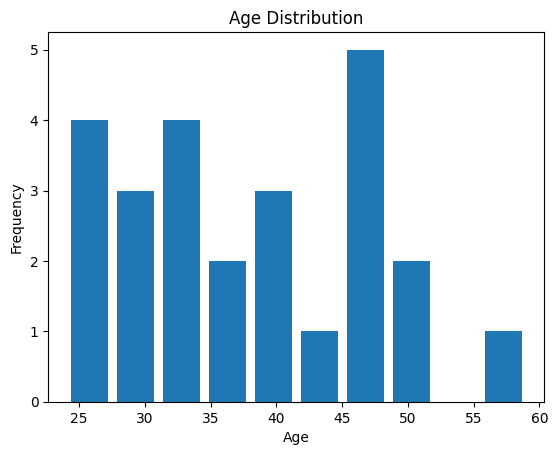

In [32]:
### Age ###
df_unique_participants["age"].plot(kind="hist", rwidth=0.8)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

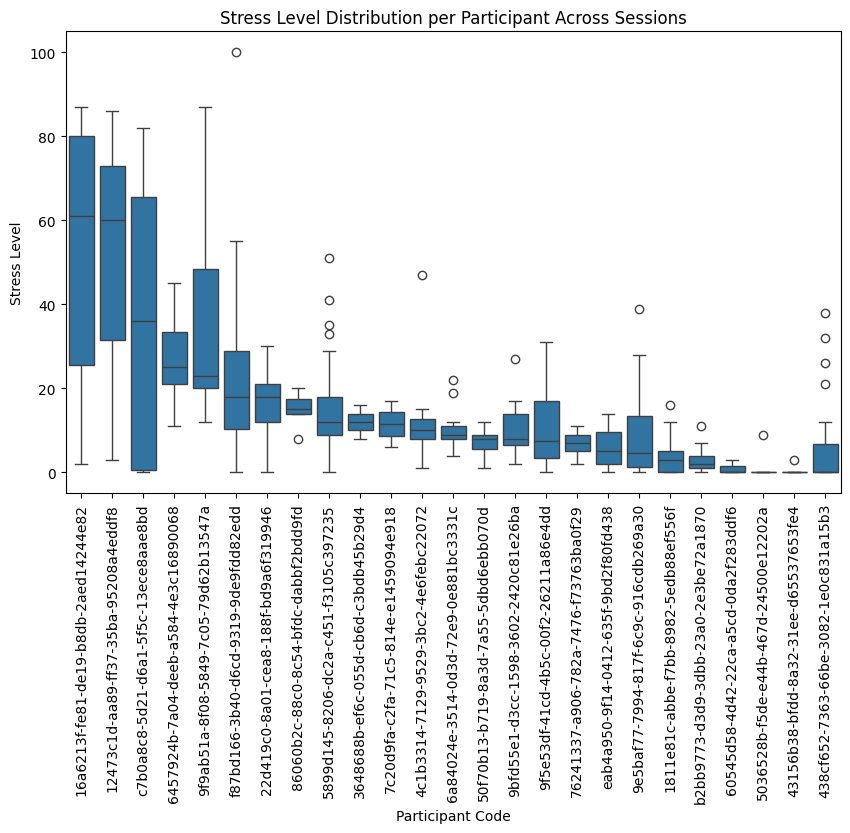

In [33]:
### Stress ###
unique_df = df_files.drop_duplicates(subset=["participant_code", "session"])

# Calculate the median stress_current for each participant_code and sort in descending order
medians = (
    unique_df.groupby("participant_code")["stress_current"]
    .median()
    .sort_values(ascending=False)
)

# Create a new DataFrame and reorder it according to the median stress_current
ordered_df = unique_df.copy()
ordered_df["participant_code"] = pd.Categorical(
    ordered_df["participant_code"], categories=medians.index, ordered=True
)

plt.figure(figsize=(10, 6))
sns.boxplot(x="participant_code", y="stress_current", data=ordered_df)
plt.title("Stress Level Distribution per Participant Across Sessions")
plt.xlabel("Participant Code")
plt.ylabel("Stress Level")
plt.xticks(rotation=90)
plt.show()

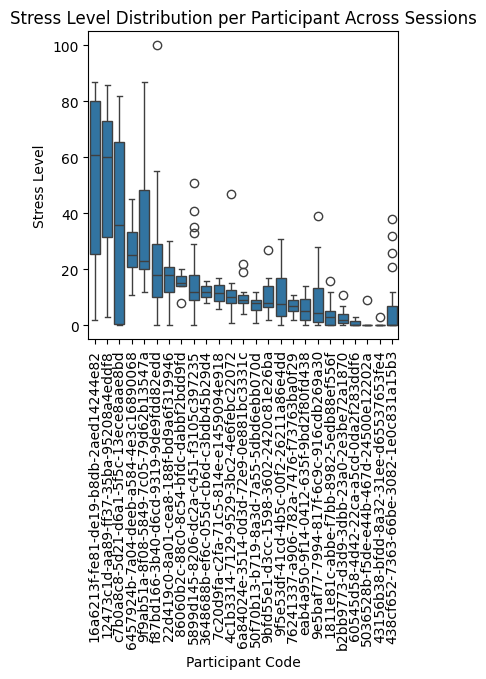

In [34]:
### Stress ###
unique_df = df_files.drop_duplicates(subset=["participant_code", "session"])

# Calculate the median stress_current for each participant_code and sort in descending order
medians = (
    unique_df.groupby("participant_code")["stress_current"]
    .median()
    .sort_values(ascending=False)
)

# Create a new DataFrame and reorder it according to the median stress_current
ordered_df = unique_df.copy()
ordered_df["participant_code"] = pd.Categorical(
    ordered_df["participant_code"], categories=medians.index, ordered=True
)

plt.figure(figsize=(4, 4))
sns.boxplot(x="participant_code", y="stress_current", data=ordered_df)
plt.title("Stress Level Distribution per Participant Across Sessions")
plt.xlabel("Participant Code")
plt.ylabel("Stress Level")
plt.xticks(rotation=90)
plt.show()
plt.close()

In [35]:
# Try to embed fonts for the paper

import matplotlib as mpl

# Set the font to a serif one
mpl.rcParams["font.family"] = "serif"
# Ensure fonts are embedded in the output
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 8

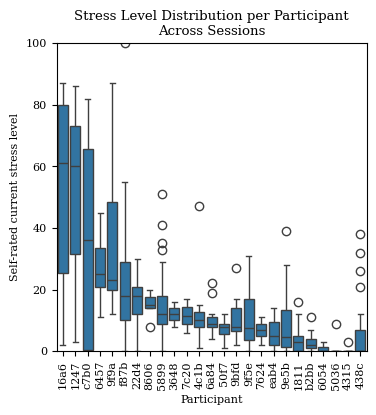

In [36]:
# Plot for paper: shorten participant UID to 4 characters

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Stress ###
unique_df = df_files.drop_duplicates(subset=["participant_code", "session"])

# Calculate the median stress_current for each participant_code and sort in descending order
medians = (
    unique_df.groupby("participant_code")["stress_current"]
    .median()
    .sort_values(ascending=False)
)

# Create a new DataFrame and reorder it according to the median stress_current
ordered_df = unique_df.copy()
ordered_df["participant_code"] = pd.Categorical(
    ordered_df["participant_code"], categories=medians.index, ordered=True
)

# Shorten the participant_code entries to 4 characters
ordered_df["participant_code"] = ordered_df["participant_code"].apply(lambda x: x[:4])

plt.figure(figsize=(4, 4))
sns.boxplot(x="participant_code", y="stress_current", data=ordered_df)
plt.title("Stress Level Distribution per Participant\nAcross Sessions")
plt.xlabel("Participant")
plt.ylabel("Self-rated current stress level")  # Y-axis label
plt.ylim(0, 100)  # Y-axis limits
plt.xticks(rotation=90)

# Save the figure
# for cur_extension in [".png", ".pdf", ".svg"]:
#     plt.savefig(
#         os.path.join("figures", f"box-individual_stress_level{cur_extension}"),
#         bbox_inches="tight",
#     )

plt.show()
plt.close()

### More compact version to save space in the paper

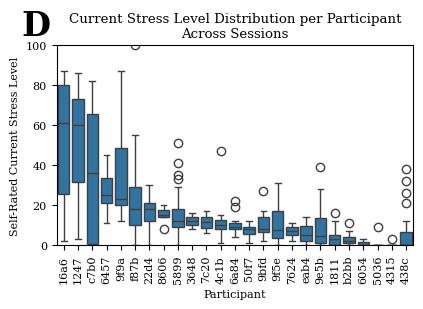

In [141]:
# Plot for paper: shorten participant UID to 4 characters

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Stress ###
unique_df = df_files.drop_duplicates(subset=["participant_code", "session"])

# Calculate the median stress_current for each participant_code and sort in descending order
medians = (
    unique_df.groupby("participant_code")["stress_current"]
    .median()
    .sort_values(ascending=False)
)

# Create a new DataFrame and reorder it according to the median stress_current
ordered_df = unique_df.copy()
ordered_df["participant_code"] = pd.Categorical(
    ordered_df["participant_code"], categories=medians.index, ordered=True
)

# Shorten the participant_code entries to 4 characters
ordered_df["participant_code"] = ordered_df["participant_code"].apply(lambda x: x[:4])

plt.figure(figsize=(4.6, 2.6))
sns.boxplot(x="participant_code", y="stress_current", data=ordered_df)
plt.title("Current Stress Level Distribution per Participant\nAcross Sessions")
plt.xlabel("Participant")
plt.ylabel("Self-Rated Current Stress Level")  # Y-axis label
plt.ylim(0, 100)  # Y-axis limits
plt.xticks(rotation=90)

# Letter for the sub-figure arrangement in the paper
plt.text(-3, 105, "D", size=24, weight="bold")

# Save the figure
for cur_extension in [".png", ".pdf", ".svg"]:
    plt.savefig(
        os.path.join(
            "figures", f"box-d-individual_stress_level-compact{cur_extension}"
        ),
        bbox_inches="tight",
    )

plt.show()
plt.close()

## Additional targets

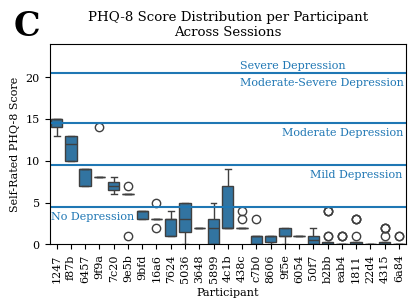

In [140]:
# Plot for paper: shorten participant UID to 4 characters

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as patches

### Stress ###
unique_df = df_files.drop_duplicates(subset=["participant_code", "session"])

# Calculate the median stress_current for each participant_code and sort in descending order
medians = (
    unique_df.groupby("participant_code")["phq_8_total_score"]
    .median()
    .sort_values(ascending=False)
)

# Create a new DataFrame and reorder it according to the median stress_current
ordered_df = unique_df.copy()
ordered_df["participant_code"] = pd.Categorical(
    ordered_df["participant_code"], categories=medians.index, ordered=True
)

# Shorten the participant_code entries to 4 characters
ordered_df["participant_code"] = ordered_df["participant_code"].apply(lambda x: x[:4])

plt.figure(figsize=(4.6, 2.6))
sns.boxplot(x="participant_code", y="phq_8_total_score", data=ordered_df)
plt.title("PHQ-8 Score Distribution per Participant\nAcross Sessions")
plt.xlabel("Participant")
plt.ylabel("Self-Rated PHQ-8 Score")  # Y-axis label
plt.ylim(0, 24)  # Y-axis limits
plt.xticks(rotation=90)

## Scale cutoffs ##
# Add a horizontal line at y=13 and 26 to separate the categories of the PSS-10
plt.axhline(y=4.5, color=sns.color_palette()[0], linestyle="-")
plt.axhline(y=9.5, color=sns.color_palette()[0], linestyle="-")
plt.axhline(y=14.5, color=sns.color_palette()[0], linestyle="-")
plt.axhline(y=20.5, color=sns.color_palette()[0], linestyle="-")
# Add text labels
plt.text(
    x=-0.4, y=3, s="No Depression", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,
plt.text(
    x=17.75, y=8, s="Mild Depression", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,
plt.text(
    x=15.8, y=13, s="Moderate Depression", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,
plt.text(
    x=12.85,
    y=19,
    s="Moderate-Severe Depression",
    color=sns.color_palette()[0],
    ha="left",
)  # fontsize=10,
plt.text(
    x=12.85, y=21, s="Severe Depression", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,

# Letter for the sub-figure arrangement in the paper
plt.text(-3, 25, "C", size=24, weight="bold")

# Save the figure
for cur_extension in [".png", ".pdf", ".svg"]:
    plt.savefig(
        os.path.join("figures", f"box-c-individual_phq8-compact{cur_extension}"),
        bbox_inches="tight",
    )

plt.show()
plt.close()

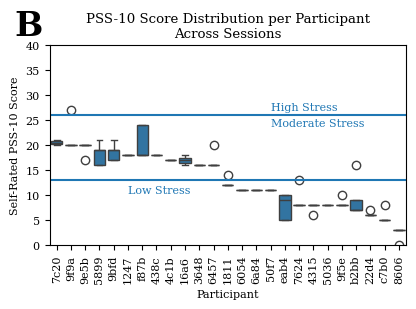

In [142]:
# Plot for paper: shorten participant UID to 4 characters

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Stress ###
unique_df = df_files.drop_duplicates(subset=["participant_code", "session"])

# Calculate the median stress_current for each participant_code and sort in descending order
medians = (
    unique_df.groupby("participant_code")["pss_10_total_score"]
    .median()
    .sort_values(ascending=False)
)

# Create a new DataFrame and reorder it according to the median stress_current
ordered_df = unique_df.copy()
ordered_df["participant_code"] = pd.Categorical(
    ordered_df["participant_code"], categories=medians.index, ordered=True
)

# Shorten the participant_code entries to 4 characters
ordered_df["participant_code"] = ordered_df["participant_code"].apply(lambda x: x[:4])

plt.figure(figsize=(4.6, 2.6))
sns.boxplot(x="participant_code", y="pss_10_total_score", data=ordered_df)
plt.title("PSS-10 Score Distribution per Participant\nAcross Sessions")
plt.xlabel("Participant")
plt.ylabel("Self-Rated PSS-10 Score")  # Y-axis label
plt.ylim(0, 40)  # Y-axis limits
plt.xticks(rotation=90)

## Scale cutoffs ##
# Add a horizontal line at y=13 and 26 to separate the categories of the PSS-10
plt.axhline(y=13, color=sns.color_palette()[0], linestyle="-")
plt.axhline(y=26, color=sns.color_palette()[0], linestyle="-")
# Add text labels
plt.text(
    x=5, y=10.5, s="Low Stress", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,
plt.text(
    x=15, y=23.75, s="Moderate Stress", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,
plt.text(
    x=15, y=27, s="High Stress", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,

# Letter for the sub-figure arrangement in the paper
plt.text(-3, 42, "B", size=24, weight="bold")

# Save the figure
for cur_extension in [".png", ".pdf", ".svg"]:
    plt.savefig(
        os.path.join("figures", f"box-b-individual_pss10-compact{cur_extension}"),
        bbox_inches="tight",
    )

plt.show()
plt.close()

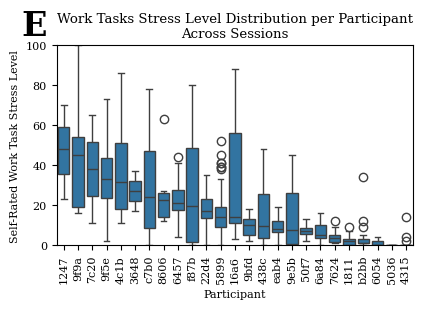

In [144]:
# Plot for paper: shorten participant UID to 4 characters

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Stress ###
unique_df = df_files.drop_duplicates(subset=["participant_code", "session"])

# Calculate the median stress_current for each participant_code and sort in descending order
medians = (
    unique_df.groupby("participant_code")["stress_work_tasks"]
    .median()
    .sort_values(ascending=False)
)

# Create a new DataFrame and reorder it according to the median stress_current
ordered_df = unique_df.copy()
ordered_df["participant_code"] = pd.Categorical(
    ordered_df["participant_code"], categories=medians.index, ordered=True
)

# Shorten the participant_code entries to 4 characters
ordered_df["participant_code"] = ordered_df["participant_code"].apply(lambda x: x[:4])

plt.figure(figsize=(4.6, 2.6))
sns.boxplot(x="participant_code", y="stress_work_tasks", data=ordered_df)
plt.title("Work Tasks Stress Level Distribution per Participant\nAcross Sessions")
plt.xlabel("Participant")
plt.ylabel("Self-Rated Work Task Stress Level")  # Y-axis label
plt.ylim(0, 100)  # Y-axis limits
plt.xticks(rotation=90)

# Letter for the sub-figure arrangement in the paper
plt.text(-3, 105, "E", size=24, weight="bold")

# Save the figure
for cur_extension in [".png", ".pdf", ".svg"]:
    plt.savefig(
        os.path.join(
            "figures", f"box-e-individual_work_stress_level-compact{cur_extension}"
        ),
        bbox_inches="tight",
    )

plt.show()
plt.close()

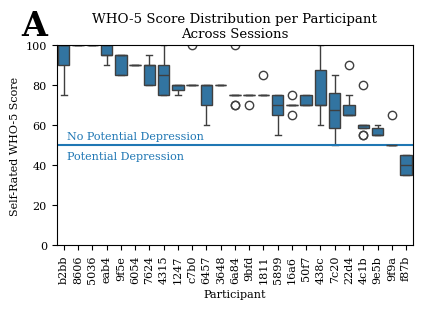

In [143]:
# Plot for paper: shorten participant UID to 4 characters

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Stress ###
unique_df = df_files.drop_duplicates(subset=["participant_code", "session"])

# Calculate the median stress_current for each participant_code and sort in descending order
medians = (
    unique_df.groupby("participant_code")["who_5_percentage_score_corrected"]
    .median()
    .sort_values(ascending=False)
)

# Create a new DataFrame and reorder it according to the median stress_current
ordered_df = unique_df.copy()
ordered_df["participant_code"] = pd.Categorical(
    ordered_df["participant_code"], categories=medians.index, ordered=True
)

# Shorten the participant_code entries to 4 characters
ordered_df["participant_code"] = ordered_df["participant_code"].apply(lambda x: x[:4])

plt.figure(figsize=(4.6, 2.6))
sns.boxplot(x="participant_code", y="who_5_percentage_score_corrected", data=ordered_df)
plt.title("WHO-5 Score Distribution per Participant\nAcross Sessions")
plt.xlabel("Participant")
plt.ylabel("Self-Rated WHO-5 Score")  # Y-axis label
plt.ylim(0, 100)  # Y-axis limits
plt.xticks(rotation=90)

## Scale cutoffs ##
# Add a horizontal line at y=50 to separate the categories of the WHO-5
plt.axhline(y=50, color=sns.color_palette()[0], linestyle="-")
# Add text labels
plt.text(
    x=0.2, y=53, s="No Potential Depression", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,
plt.text(
    x=0.2, y=43, s="Potential Depression", color=sns.color_palette()[0], ha="left"
)  # fontsize=10,

# Letter for the sub-figure arrangement in the paper
plt.text(-3, 105, "A", size=24, weight="bold")

# Save the figure
for cur_extension in [".png", ".pdf", ".svg"]:
    plt.savefig(
        os.path.join("figures", f"box-a-individual_who5-compact{cur_extension}"),
        bbox_inches="tight",
    )

plt.show()
plt.close()